In [1]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import preprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, Reshape

import numpy as np
import pandas as pd

### data

In [2]:
data = pd.read_csv("colors.csv")
names = data["name"]
data.head()

,name,red,green,blue
0,18th Century Green,165,147,68
1,1975 Earth Red,123,70,59
2,1989 Miami Hotline,221,51,102
3,20000 Leagues Under the Sea,25,25,112
4,3AM in Shibuya,34,85,119


In [3]:
(names.str.len())

0        18
1        14
2        18
3        27
4        14
         ..
18601    14
18602    15
18603     7
18604     4
18605    11
Name: name, Length: 18606, dtype: int64

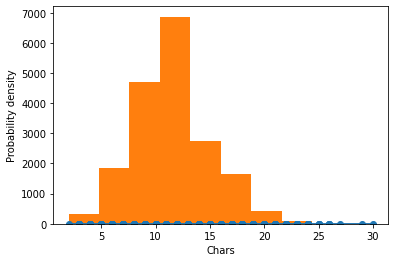

In [4]:
h = sorted(names.str.len().values)
import scipy.stats as stats
import pylab as plt

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
plt.plot(h,fit,'-o')
plt.hist(h) 
#plt.hist(h,normal=True)      #use this to draw histogram of your data
plt.xlabel('Chars')
plt.ylabel('Probability density')
plt.show()

# Data Prep

In [5]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
print(padded_names.shape)

(18606, 25)


In [19]:
padded_names

array([[ 0,  0,  0, ...,  1,  1,  7],
       [ 0,  0,  0, ...,  4,  1, 13],
       [ 0,  0,  0, ...,  5,  7,  1],
       ...,
       [ 0,  0,  0, ..., 16,  8,  4],
       [ 0,  0,  0, ..., 12,  7,  5],
       [ 0,  0,  0, ...,  6, 12,  1]], dtype=int32)

In [55]:
padded_names.shape

(18606, 25)

In [20]:
names[0]

'18th Century Green'

In [21]:
padded_names[0]

array([ 0,  0,  0,  0,  0,  0,  0, 54, 38, 10, 16,  3, 11,  1,  7, 10, 12,
        4, 19,  3, 14,  4,  1,  1,  7], dtype=int32)

### One hot encode

In [24]:
# len of 89
print(t.word_index)

{'e': 1, 'a': 2, ' ': 3, 'r': 4, 'i': 5, 'l': 6, 'n': 7, 'o': 8, 's': 9, 't': 10, 'c': 11, 'u': 12, 'd': 13, 'g': 14, 'p': 15, 'h': 16, 'b': 17, 'm': 18, 'y': 19, 'w': 20, 'k': 21, 'f': 22, 'v': 23, 'z': 24, 'j': 25, 'q': 26, 'x': 27, "'": 28, '-': 29, 'ō': 30, 'è': 31, 'é': 32, 'ā': 33, 'á': 34, 'ó': 35, 'ū': 36, '0': 37, '8': 38, '.': 39, 'ē': 40, 'ī': 41, 'ǎ': 42, '!': 43, 'í': 44, '&': 45, 'ǜ': 46, '9': 47, '2': 48, 'à': 49, 'ǐ': 50, '’': 51, '6': 52, 'ú': 53, '1': 54, '3': 55, 'â': 56, '4': 57, 'ǔ': 58, 'ì': 59, '7': 60, '5': 61, 'ê': 62, 'ö': 63, 'ł': 64, 'š': 65, 'ü': 66, '₂': 67, 'ò': 68, 'ñ': 69, 'ě': 70, 'ń': 71, 'ä': 72, 'œ': 73, 'ß': 74, '%': 75, 'ı': 76, 'ż': 77, '/': 78, 'î': 79, 'ë': 80, '(': 81, ')': 82, 'å': 83, '$': 84, 'я': 85, 'ő': 86, 'ğ': 87, 'ç': 88, 'ù': 89}


In [25]:
from tensorflow.python.keras.utils import np_utils
one_hot_names = np_utils.to_categorical(padded_names)

In [39]:
one_hot_names[0].shape

(25, 90)

In [41]:
one_hot_names[0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [27]:
one_hot_names.shape

(18606, 25, 90)

### Data Normalization

In [28]:
# Always normalize pixels!
# The RGB values are between 0 - 255
# scale them to be between 0 - 1
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(data["red"]), norm(data["green"]), norm(data["blue"])])

In [29]:
normalized_values

array([[0.64705882, 0.57647059, 0.26666667],
       [0.48235294, 0.2745098 , 0.23137255],
       [0.86666667, 0.2       , 0.4       ],
       ...,
       [0.80392157, 0.83529412, 0.83529412],
       [0.        , 0.5372549 , 0.58823529],
       [0.14117647, 0.54509804, 0.8       ]])

# Building the Model

In [31]:
# LSTM very COMPLICATED!!
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, 90)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [33]:
history = model.fit(one_hot_names, normalized_values,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
466/466 [==============================] - 39s 84ms/step - loss: 0.0616 - acc: 0.6326 - val_loss: 0.0607 - val_acc: 0.5991
Epoch 2/10
466/466 [==============================] - 36s 78ms/step - loss: 0.0595 - acc: 0.6352 - val_loss: 0.0586 - val_acc: 0.6169
Epoch 3/10
466/466 [==============================] - 36s 77ms/step - loss: 0.0571 - acc: 0.6344 - val_loss: 0.0570 - val_acc: 0.5825
Epoch 4/10
466/466 [==============================] - 36s 78ms/step - loss: 0.0551 - acc: 0.6411 - val_loss: 0.0574 - val_acc: 0.6166
Epoch 5/10
466/466 [==============================] - 38s 82ms/step - loss: 0.0530 - acc: 0.6399 - val_loss: 0.0564 - val_acc: 0.5919
Epoch 6/10
466/466 [==============================] - 39s 84ms/step - loss: 0.0509 - acc: 0.6450 - val_loss: 0.0558 - val_acc: 0.6263
Epoch 7/10
466/466 [==============================] - 36s 77ms/step - loss: 0.0487 - acc: 0.6462 - val_loss: 0.0558 - val_acc: 0.6290
Epoch 8/10
466/466 [==============================] - 36s 76ms

### Generate Colors

In [58]:
# plot a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

def scale(n):
    return int(n * 255) 

def predict(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    one_hot = np_utils.to_categorical(padded, num_classes=90)
    pred = model.predict(np.array(one_hot))[0]
    print(pred)
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

[0.4217394  0.46592587 0.3894645 ]
forest, R,G,B: 107 118 99


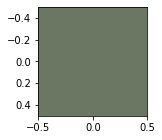

[0.52163583 0.63600016 0.5454346 ]
covid, R,G,B: 133 162 139


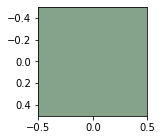

In [67]:
predict("forest")
predict("COVID")